# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [19]:
# !curl -L https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1 -o Train_rev1.csv.tar.gz
# !tar -xvzf ./Train_rev1.csv.tar.gz
data = pd.read_csv("Train_rev1.csv", index_col=None)
print(data.shape)
data.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons of money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [20]:
data.drop(['Id'], axis=1, inplace=True)

In [21]:
data.shape

(244768, 11)

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

### Preprocessing text data

Applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [22]:
print("Raw text:")
print(data["Title"][2::100000].values)

Raw text:
['Modelling and simulation analyst' 'Economics Teacher NQT'
 'Web Designer  HTML, CSS, JavaScript, Photoshop  Macclesfield']


In [23]:
data = data[:55000]
print(data["Title"].astype(str).values)
data.shape

['Engineering Systems Analyst' 'Stress Engineer Glasgow'
 'Modelling and simulation analyst' ...
 'Business Development Executive up to ****' 'Audit Technitian'
 'Marketing Executive']


(55000, 11)

In [24]:
data.Title[54321]

'International Digital Account Manager (German)'

In [25]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

# see task above
# <YOUR CODE HERE>
data['Title'] = np.array([preprocess(comment) for comment in data["Title"].astype(str).values])
data['FullDescription'] = np.array([preprocess(comment) for comment in data["FullDescription"].astype(str).values])

In [26]:
data[2::100]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
2,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
102,revenue manager luxury resort hotel & spa live...,the hotel revenue manager luxury resort hotel ...,Jersey Channel Isles,Jersey,NaN,NaN,Marshall Human Resources,Hospitality & Catering Jobs,"From 26,000 to 27,000 per annum live-in availa...",26500,caterer.com
202,nursing home staff nurse job surrey,nursing home staff nurse job surrey our client...,Surrey,Surrey,full_time,NaN,NaN,Healthcare & Nursing Jobs,12.00 per hour,23040,careworx.co.uk
302,support worker job skipton,support worker job skipton job title : paediat...,"Skipton, North Yorkshire",Skipton,part_time,NaN,NaN,Healthcare & Nursing Jobs,7.17 to 9.00 per hour,15523,careworx.co.uk
402,pulse staffing are currently seeking nurses to...,pulse staffing are currently seeking nurses to...,"Sussex, UK",West Sussex,NaN,NaN,NaN,Healthcare & Nursing Jobs,17.00ph to 27.20ph per hour,42432,careworx.co.uk
...,...,...,...,...,...,...,...,...,...,...,...
54502,technical sales professional,my client is looking for an enthusiastic sales...,Kidlington Oxfordshire South East,Kidlington,NaN,permanent,Plus One Personnel,Sales Jobs,"From 20,000 to 22,000 per annum",21000,totaljobs.com
54602,service delivery specialist / post sales speci...,our client is an information technology distri...,London South East,South East London,NaN,permanent,Tectre,IT Jobs,"Upto 50,000 per annum OTE",50000,totaljobs.com
54702,account manager design,account manager ( branding / packaging / desig...,Bristol Avon South West,UK,NaN,permanent,Pure Recruitment,"PR, Advertising & Marketing Jobs","From 25,000 to 30,000 per annum",27500,totaljobs.com
54802,recruitment consultant,recruitment consultant central london overview...,Central London / West End London South East,London,NaN,permanent,Leverage Appointments,HR & Recruitment Jobs,OTE of up to 100k+ Depending on experience,100000,totaljobs.com


In [27]:
data["FullDescription"][2][:50]

'mathematical modeller / simulation analyst / opera'

Now we can assume that our text is a space-separated list of tokens:

In [28]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2    mathematical modeller / simulation analyst / o...
Name: FullDescription, dtype: object


In [129]:
# data.to_csv('data_tokenized.csv', index=False)
data = pd.read_csv('data_tokenized.csv')
data.sample(3)

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
40990,seo specialist,this is an excellent opportunity for an experi...,Suffolk,Suffolk,full_time,permanent,BRAND RECRUITMENT,Teaching Jobs,30000 per annum,30000,jobs.guardian.co.uk
48225,"software developer / programmer c , sql","c software developer / programmer with . net ,...","Stockport,Manchester,Greater Manchester,Cheadl...",UK,NaN,permanent,IT Executive Recruitment,IT Jobs,22k - 37k pa,29500,jobsite.co.uk
25831,payroll clerk part time,an opportunity has been created in blackburn f...,Blackburn,Blackburn,full_time,NaN,NaN,Accounting & Finance Jobs,"16,000.00 - 17,000.00 per year",16500,Jobcentre Plus


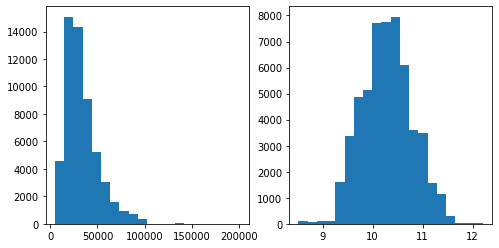

In [130]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [131]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
32848,assistant manager new opening rest / bar readi...,a fantastic opportunity has arisen for an assi...,"Reading, Berkshire, UK, Berkshire",Reading,NaN,NaN,PTHR International Restaurants Bars,Hospitality & Catering Jobs,"From 22,000 to 25,000 per annum 5k Bonus poten...",23500,jobs.catererandhotelkeeper.com,10.064798
45510,quality auditor,this is an exciting opportunity to join a glob...,South East,South East London,NaN,permanent,Michael Page International PLC,Engineering Jobs,38000 to 40000,39000,justengineers.net,10.571342
42634,pipefitter / welder,**** x pipefitter / welder required to work on...,Berkhamsted,Berkhamsted,full_time,NaN,NaN,Manufacturing Jobs,15.00 - 16.00 per hour,29760,Jobcentre Plus,10.300954


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [132]:
from collections import Counter
import re
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }

# <YOUR CODE HERE>


# token_counts = [Counter(re.findall(r'\w+', txt)) for txt in data['Title'].values]
# token_counts.append( [Counter(re.findall(r'\w+', txt)) for txt in data['FullDescription'].values])

# hint: you may or may not want to use collections.Counter
print(data['Title'].head)
print(data['FullDescription'].head)

<bound method NDFrame.head of 0                              engineering systems analyst
1                                  stress engineer glasgow
2                         modelling and simulation analyst
3        engineering systems analyst / mathematical mod...
4              pioneer , miser engineering systems analyst
                               ...                        
54995                   rent acounting manager cirencester
54996                         c web developer / programmer
54997            business development executive up to ****
54998                                     audit technitian
54999                                  marketing executive
Name: Title, Length: 55000, dtype: object>
<bound method NDFrame.head of 0        engineering systems analyst dorking surrey sal...
1        stress engineer glasgow salary **** to **** we...
2        mathematical modeller / simulation analyst / o...
3        engineering systems analyst / mathematical mod...
4        pio

In [133]:
filtered = [w for w in data['Title'] if w.isalnum()]
token_counts = Counter(filtered)
print(token_counts.most_common(3))
filtered = [w for w in data['FullDescription'] if w.isalnum()]

[('cleaner', 189), ('administrator', 89), ('labourer', 52)]


In [145]:
filtered[:50]

[]

In [146]:
token_counts

{'rgn': 20,
 'bookkeeper': 19,
 'buyer': 39,
 'receptionist': 41,
 'estimator': 24,
 'electrician': 30,
 'cleaner': 189,
 'administrator': 89,
 'technician': 13,
 'telesales': 27,
 'paraplanner': 16,
 'paralegal': 15,
 'solicitor': 19,
 'labourer': 52,
 'toolmaker': 11,
 'accountant': 28,
 'cook': 14,
 'driver': 11,
 'groundworker': 13,
 'chef': 22,
 'housekeeper': 11,
 'carer': 11,
 'pa': 16}

In [135]:
token_counts.update(Counter(filtered))
token_counts

Counter({'manager': 10,
         'borer': 1,
         'rgn': 20,
         'pharmacist': 3,
         'odp': 4,
         'hygienist': 2,
         'bookkeeper': 19,
         'rmn': 3,
         'NaN': 1,
         'fitter': 3,
         'nurses': 5,
         'teachers': 2,
         'developer': 8,
         'radiographer': 3,
         'consultant': 3,
         'analyst': 7,
         'sonographer': 3,
         'draftsperson': 1,
         'eyfs': 1,
         'buyer': 39,
         'telephonist': 1,
         'receptionist': 41,
         'audiologist': 1,
         'estimator': 24,
         'upholsterer': 4,
         'draughtsperson': 6,
         'electrician': 30,
         'expeditor': 3,
         'cleaner': 189,
         'administrator': 89,
         'pmo': 1,
         'technician': 13,
         'valuer': 4,
         'adminstor': 1,
         'fettlers': 1,
         'trainer': 3,
         'grinder': 3,
         'polisher': 1,
         'telesales': 27,
         'paraplanner': 16,
         'paralega

In [136]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(540000, 2700000)
assert len(token_counts) in range(40000, 210000)
print('Correct!')

Total unique tokens : 256
('cleaner', 189)
('administrator', 89)
('labourer', 52)
('receptionist', 41)
('buyer', 39)
...
('strategist', 1)
('semisenior', 1)
('adjudicator', 1)


AssertionError: 

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [ ]:
{item: value for item, value in sorted(token_counts.items(), key = lambda item: item[1], reverse=True)}

Now filter tokens a list of all tokens that occur at least 10 times.

In [137]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# <YOUR CODE HERE>
token_counts = {key:val for key, val in token_counts.items() if val > 10}
token_counts

{'rgn': 20,
 'bookkeeper': 19,
 'buyer': 39,
 'receptionist': 41,
 'estimator': 24,
 'electrician': 30,
 'cleaner': 189,
 'administrator': 89,
 'technician': 13,
 'telesales': 27,
 'paraplanner': 16,
 'paralegal': 15,
 'solicitor': 19,
 'labourer': 52,
 'toolmaker': 11,
 'accountant': 28,
 'cook': 14,
 'driver': 11,
 'groundworker': 13,
 'chef': 22,
 'housekeeper': 11,
 'carer': 11,
 'pa': 16}

<function ndarray.nonzero>

In [138]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
# <YOUR CODE HERE>
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 2


AssertionError: 

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [153]:
# token_to_id = [w for w in data['FullDescription']] # <YOUR CODE HERE>
# i = 0
# k = {i++:val for key, val in token_counts.items()}
# k
token_to_id = token_counts

In [154]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

AssertionError: 

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [23]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [24]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10809 30163  2168     1     1]
 [15022  2846     1     1     1]
 [27647 10203    16 15217 10806]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [25]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [26]:
data.drop(['LocationRaw', 'SalaryRaw', 'SalaryNormalized', 'SourceName'], axis=1, inplace=True)
data.columns

Index(['Title', 'FullDescription', 'LocationNormalized', 'ContractType',
       'ContractTime', 'Company', 'Category', 'Log1pSalary'],
      dtype='object')

In [27]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [30]:
data_train

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,Log1pSalary
0,senior support worker,senior support worker wanted a senior support ...,Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,9.711540
1,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West London,NaN,permanent,Other,Scientific & QA Jobs,10.463132
2,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,NaN,permanent,Other,Engineering Jobs,10.714440
3,"core java engineer london , big data","core java engineer london , big data , mysql ,...",London,NaN,permanent,Engage PSG,IT Jobs,11.042938
4,driver,"**** driver reqd for busy parcel round , exper...",Brentwood,full_time,NaN,Other,Logistics & Warehouse Jobs,9.798182
...,...,...,...,...,...,...,...,...
195809,senior solutions architect,a senior solutions architect is required to jo...,London,NaN,permanent,NaN,IT Jobs,11.277216
195810,charity administrator,job title : charity administrator salary : pou...,The City,NaN,permanent,Other,Social work Jobs,9.852247
195811,senior consumer insight manager communications...,about the role the senior consumer insight man...,Central London,NaN,NaN,NaN,"PR, Advertising & Marketing Jobs",10.859018
195812,"customer service manager , guildford , motor t...","automotive , motor trade job : customer servic...",Guildford,NaN,NaN,Perfect Placement,Trade & Construction Jobs,10.308986


In [28]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [29]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[27647, 29895, 33676,     1,     1,     1,     1],
        [29241,   197, 19177, 20044, 15556, 23164,  4053],
        [10611, 30414, 17748,    33,  8707, 29159,    65]], dtype=int32),
 'FullDescription': array([[27647, 29895, 33676, 32941,   984, 27647, 29895, 33676, 16453,
         32941],
        [29241,   197, 19177, 20044, 15556, 23164,  4053, 25513,   907,
            82],
        [30748, 21958, 20603,  6411, 16453,  8167, 27495,   984, 30414,
         17748]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

In [25]:
make_batch(data_train[:105], max_len=10)['Title'].shape

(105, 10)

In [26]:
make_batch(data_train[:15], max_len=10)['Categorical'].shape

(15, 3768)

In [27]:
make_batch(data_train[:15], max_len=10)['Log1pSalary'].shape

(15,)

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [31]:
import keras
import keras.layers as L

In [32]:
keras.backend.clear_session()

In [33]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[10], name="Title")
    l_descr = L.Input(shape=[10], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    # <YOUR CODE HERE>

    output_layer = "?"
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [34]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100], max_len=10))
dummy_loss = model.train_on_batch(make_batch(data_train[:100], max_len=10), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

2022-02-02 10:17:28.079468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 10:17:28.166084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 10:17:28.166249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 10:17:28.166866: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FullDescription (InputLayer)    [(None, 10)]         0                                            
__________________________________________________________________________________________________
Title (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 10)       341600      FullDescription[0][0]            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 10)       341600      Title[0][0]                      
______________________________________________________________________________________________

2022-02-02 10:17:33.550164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/gevorg/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
2022-02-02 10:17:35.574415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204
2022-02-02 10:17:36.382795: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [35]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [36]:
batch_size = 256
epochs = 25            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05, max_len=10), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True, max_len=10),
                    validation_steps=data_val.shape[0] // batch_size)

Epoch 1/25
100/100 [==============================] - 5s 44ms/step - loss: 12.4843 - mean_absolute_error: 2.0073 - val_loss: 0.1939 - val_mean_absolute_error: 0.3441
Epoch 2/25
100/100 [==============================] - 4s 41ms/step - loss: 0.1712 - mean_absolute_error: 0.3228 - val_loss: 0.1531 - val_mean_absolute_error: 0.3044
Epoch 3/25
100/100 [==============================] - 4s 40ms/step - loss: 0.1465 - mean_absolute_error: 0.2959 - val_loss: 0.1348 - val_mean_absolute_error: 0.2833
Epoch 4/25
100/100 [==============================] - 4s 41ms/step - loss: 0.1319 - mean_absolute_error: 0.2782 - val_loss: 0.1186 - val_mean_absolute_error: 0.2631
Epoch 5/25
100/100 [==============================] - 4s 41ms/step - loss: 0.1135 - mean_absolute_error: 0.2556 - val_loss: 0.1061 - val_mean_absolute_error: 0.2469
Epoch 6/25
100/100 [==============================] - 4s 41ms/step - loss: 0.1045 - mean_absolute_error: 0.2430 - val_loss: 0.0980 - val_mean_absolute_error: 0.2355
Epoch 7/2

In [37]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train', max_len=10)
print_metrics(model, data_val, name='Val', max_len=10);

Train results:
Mean square error: 0.05291
Mean absolute error: 0.16851
Val results:
Mean square error: 0.07429
Mean absolute error: 0.20189
